   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 73.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Reading CSV file...
Randomly sampling 5000 rows from 52004 total rows...
Initializing models...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Analyzing reviews...
Progress: 2.0% (100/5000 reviews processed)
Progress: 4.0% (200/5000 reviews processed)
Progress: 6.0% (300/5000 reviews processed)
Progress: 8.0% (400/5000 reviews processed)
Progress: 10.0% (500/5000 reviews processed)
Progress: 12.0% (600/5000 reviews processed)
Progress: 14.0% (700/5000 reviews processed)
Progress: 16.0% (800/5000 reviews processed)
Progress: 18.0% (900/5000 reviews processed)
Progress: 20.0% (1000/5000 reviews processed)
Progress: 22.0% (1100/5000 reviews processed)
Progress: 24.0% (1200/5000 reviews processed)
Progress: 26.0% (1300/5000 reviews processed)
Progress: 28.0% (1400/5000 reviews processed)
Progress: 30.0% (1500/5000 reviews processed)
Progress: 32.0% (1600/5000 reviews processed)
Progress: 34.0% (1700/5000 reviews processed)
Progress: 36.0% (1800/5000 reviews processed)
Progress: 38.0% (1900/5000 reviews processed)
Progress: 40.0% (2000/5000 reviews processed)
Progress: 42.0% (2100/5000 reviews processed)
Progress: 44.0% (2200/5000

<ipython-input-1-61d919296cfc>:153: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')



Analysis Summary:
Number of reviews analyzed: 5000
Average Google Score: 4.56
Average Overall Sentiment: 4.11

Aspect Scores:

overall_sentiment:
  Mean: 4.11
  Std: 0.81
  Correlation with Google Score: 0.347

doctors_sentiment:
  Mean: 3.44
  Std: 0.73
  Correlation with Google Score: 0.111

staff_sentiment:
  Mean: 3.32
  Std: 0.57
  Correlation with Google Score: 0.189

service_sentiment:
  Mean: 3.52
  Std: 0.67
  Correlation with Google Score: 0.224

price_sentiment:
  Mean: 3.00
  Std: 0.13
  Correlation with Google Score: 0.045

food_sentiment:
  Mean: 3.05
  Std: 0.23
  Correlation with Google Score: 0.099

facilities_sentiment:
  Mean: 3.11
  Std: 0.36
  Correlation with Google Score: 0.123


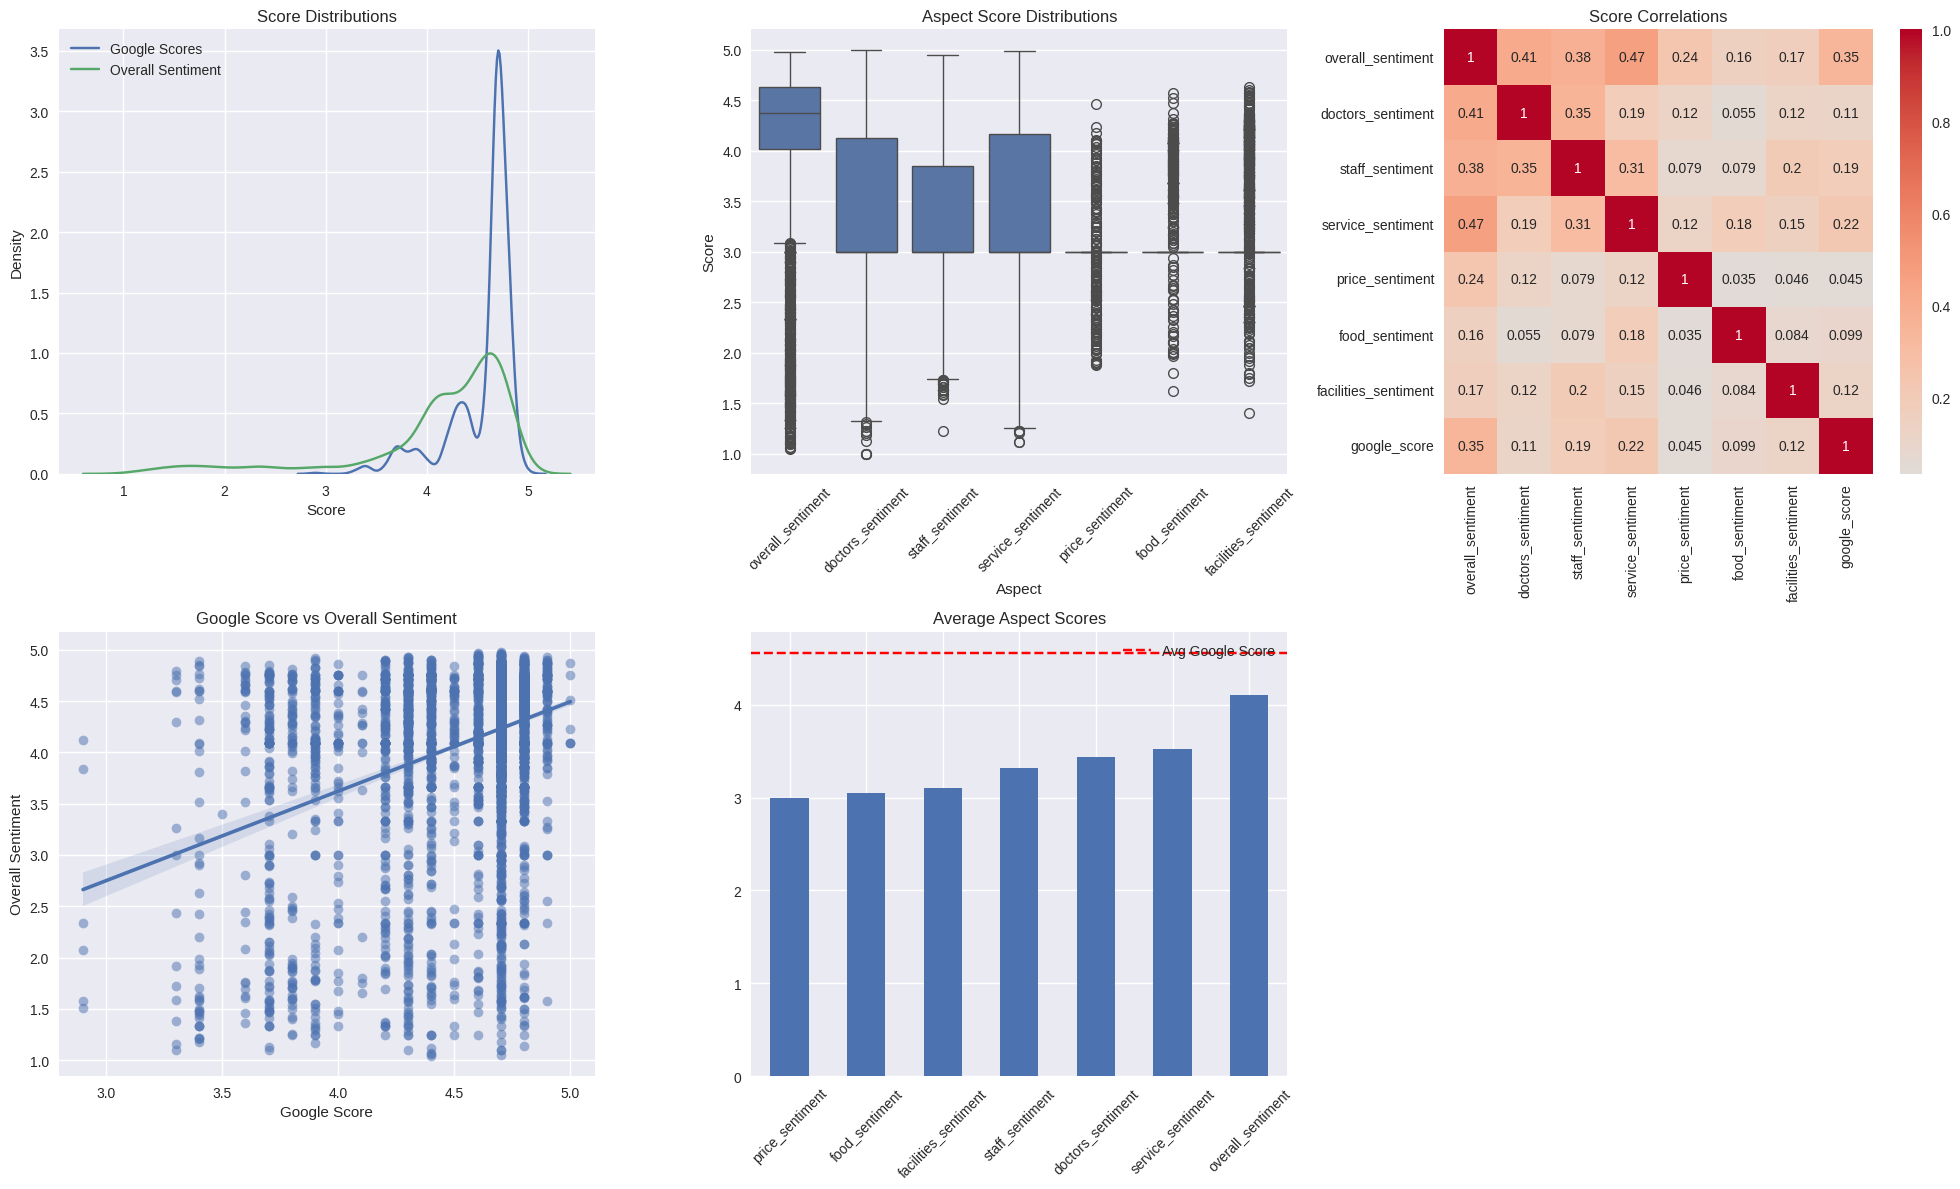

In [1]:
# Install required packages - note the correct package names
!pip install transformers torch vaderSentiment nltk textblob spacy seaborn matplotlib pandas numpy scipy
# Download required language model
!python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import spacy
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

class MultiModelABSA:
    def __init__(self):
        # Initialize all models
        self.nlp = spacy.load('en_core_web_sm')
        self.vader = SentimentIntensityAnalyzer()
        self.sentiment_transformer = pipeline(
            "sentiment-analysis",
            model="nlptown/bert-base-multilingual-uncased-sentiment"
        )

        # Define aspects and their related terms
        self.aspects = {
            'doctors': {
                'terms': ['doctor', 'dr', 'physician', 'medical', 'treatment', 'diagnosis'],
                'weight': 1.2
            },
            'staff': {
                'terms': ['staff', 'nurse', 'attendant', 'employee', 'worker'],
                'weight': 1.0
            },
            'service': {
                'terms': ['service', 'care', 'attention', 'support', 'assistance', 'help'],
                'weight': 1.0
            },
            'price': {
                'terms': ['price', 'cost', 'expensive', 'cheap', 'affordable', 'money'],
                'weight': 0.8
            },
            'food': {
                'terms': ['food', 'meal', 'nutrition', 'diet', 'eating'],
                'weight': 0.8
            },
            'facilities': {
                'terms': ['room', 'bed', 'facility', 'equipment', 'infrastructure', 'ward', 'ICU'],
                'weight': 0.9
            }
        }

    def get_textblob_sentiment(self, text):
        """Get sentiment using TextBlob"""
        if not isinstance(text, str):
            return 0.0
        return TextBlob(text).sentiment.polarity

    def get_vader_sentiment(self, text):
        """Get sentiment using VADER"""
        if not isinstance(text, str):
            return 0.0
        scores = self.vader.polarity_scores(text)
        return scores['compound']

    def get_transformer_sentiment(self, text):
        """Get sentiment using BERT"""
        if not isinstance(text, str):
            return 0.0
        try:
            result = self.sentiment_transformer(text[:512])[0]  # Truncate to max length
            # Convert 1-5 star rating to -1 to 1 scale
            return (float(result['label'][0]) - 3) / 2
        except Exception as e:
            print(f"Transformer error: {str(e)}")
            return 0.0

    def get_spacy_dependency_sentiment(self, text, aspect_terms):
        """Analyze sentiment using dependency parsing"""
        if not isinstance(text, str):
            return 0.0
        doc = self.nlp(text)
        aspect_sentiments = []

        for token in doc:
            if token.text.lower() in aspect_terms:
                for child in token.children:
                    if child.dep_ in ['amod', 'advmod', 'compound']:
                        sentiment = self.get_textblob_sentiment(child.text)
                        aspect_sentiments.append(sentiment)

        return np.mean(aspect_sentiments) if aspect_sentiments else 0.0

    def normalize_score(self, score):
        """Convert sentiment score to 1-5 scale"""
        return max(1.0, min(5.0, 1 + (score + 1) * 2))

    def get_ensemble_sentiment(self, text, aspect):
        """Combine multiple sentiment models with weights"""
        if not isinstance(text, str):
            return 3.0

        aspect_terms = self.aspects[aspect]['terms']
        aspect_weight = self.aspects[aspect]['weight']

        sentences = sent_tokenize(text)
        aspect_sentences = [
            sentence for sentence in sentences
            if any(term in sentence.lower() for term in aspect_terms)
        ]

        if not aspect_sentences:
            return 3.0

        sentiments = []
        for sentence in aspect_sentences:
            weighted_sentiment = (
                self.get_textblob_sentiment(sentence) * 0.2 +
                self.get_vader_sentiment(sentence) * 0.3 +
                self.get_transformer_sentiment(sentence) * 0.3 +
                self.get_spacy_dependency_sentiment(sentence, aspect_terms) * 0.2
            )
            sentiments.append(weighted_sentiment)

        final_sentiment = np.mean(sentiments) * aspect_weight
        return self.normalize_score(final_sentiment)

    def analyze_review(self, text):
        """Analyze a single review for all aspects"""
        if not isinstance(text, str):
            text = str(text)

        results = {
            'overall_sentiment': self.normalize_score(np.mean([
                self.get_textblob_sentiment(text),
                self.get_vader_sentiment(text),
                self.get_transformer_sentiment(text)
            ]))
        }

        for aspect in self.aspects:
            results[f'{aspect}_sentiment'] = self.get_ensemble_sentiment(text, aspect)

        return results

class ReviewVisualizer:
    def __init__(self, results_df):
        self.results_df = results_df
        plt.style.use('seaborn')

    def plot_model_comparisons(self):
        """Create visualization comparing different model scores"""
        fig = plt.figure(figsize=(20, 12))

        # Score Distribution
        plt.subplot(2, 3, 1)
        if 'google_score' in self.results_df.columns:
            sns.kdeplot(data=self.results_df, x='google_score', label='Google Scores')
        sns.kdeplot(data=self.results_df, x='overall_sentiment', label='Overall Sentiment')
        plt.title('Score Distributions')
        plt.xlabel('Score')
        plt.ylabel('Density')
        plt.legend()

        # Aspect Scores Boxplot
        aspect_cols = [col for col in self.results_df.columns if col.endswith('_sentiment')]
        aspect_data = self.results_df[aspect_cols].melt()
        plt.subplot(2, 3, 2)
        sns.boxplot(x='variable', y='value', data=aspect_data)
        plt.xticks(rotation=45)
        plt.title('Aspect Score Distributions')
        plt.xlabel('Aspect')
        plt.ylabel('Score')

        # Correlation Heatmap
        plt.subplot(2, 3, 3)
        corr_cols = [col for col in self.results_df.columns
                    if col.endswith('_sentiment') or col == 'google_score']
        corr_matrix = self.results_df[corr_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Score Correlations')

        # Scatter plot
        if 'google_score' in self.results_df.columns:
            plt.subplot(2, 3, 4)
            sns.regplot(data=self.results_df, x='google_score', y='overall_sentiment',
                       scatter_kws={'alpha':0.5})
            plt.title('Google Score vs Overall Sentiment')
            plt.xlabel('Google Score')
            plt.ylabel('Overall Sentiment')

        # Average Aspect Scores
        plt.subplot(2, 3, 5)
        mean_aspects = self.results_df[aspect_cols].mean().sort_values()
        mean_aspects.plot(kind='bar')
        if 'google_score' in self.results_df.columns:
            plt.axhline(y=self.results_df['google_score'].mean(), color='r',
                       linestyle='--', label='Avg Google Score')
        plt.title('Average Aspect Scores')
        plt.xticks(rotation=45)
        plt.legend()

        plt.tight_layout()
        return fig

    def create_summary_report(self):
        """Generate text summary of the analysis"""
        aspect_cols = [col for col in self.results_df.columns if col.endswith('_sentiment')]

        summary = {
            'overall_stats': {
                'num_reviews': len(self.results_df),
                'avg_google_score': self.results_df['google_score'].mean()
                    if 'google_score' in self.results_df.columns else None,
                'avg_sentiment_score': self.results_df['overall_sentiment'].mean()
            },
            'aspect_scores': {}
        }

        for aspect in aspect_cols:
            correlation = (
                pearsonr(self.results_df['google_score'], self.results_df[aspect])[0]
                if 'google_score' in self.results_df.columns
                else None
            )

            summary['aspect_scores'][aspect] = {
                'mean': self.results_df[aspect].mean(),
                'std': self.results_df[aspect].std(),
                'correlation': correlation
            }

        return summary

def analyze_reviews_from_csv(csv_path, sample_size=5000, random_seed=42):
    """Main function to analyze reviews from CSV file with random sampling"""
    try:
        print("Reading CSV file...")
        df = pd.read_csv(csv_path)

        # Add random sampling
        print(f"Randomly sampling {sample_size} rows from {len(df)} total rows...")
        df = df.sample(n=min(sample_size, len(df)), random_state=random_seed)

        required_columns = ['text']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        print("Initializing models...")
        analyzer = MultiModelABSA()

        print("Analyzing reviews...")
        results = []
        total_reviews = len(df)

        # Add progress tracking
        for idx, row in df.iterrows():
            review_text = str(row['text'])
            review_results = analyzer.analyze_review(review_text)
            review_results['review_text'] = review_text

            if 'totalScore' in df.columns:
                try:
                    review_results['google_score'] = float(row['totalScore'])
                except (ValueError, TypeError):
                    print(f"Warning: Invalid score for review {idx}")
                    review_results['google_score'] = None

            results.append(review_results)

            # Update progress every 100 reviews
            if len(results) % 100 == 0:
                progress = (len(results) / total_reviews) * 100
                print(f"Progress: {progress:.1f}% ({len(results)}/{total_reviews} reviews processed)")

        results_df = pd.DataFrame(results)

        print("\nGenerating visualizations...")
        visualizer = ReviewVisualizer(results_df)
        figures = visualizer.plot_model_comparisons()
        summary = visualizer.create_summary_report()

        print("\nAnalysis Summary:")
        print("================")
        print(f"Number of reviews analyzed: {summary['overall_stats']['num_reviews']}")
        if summary['overall_stats']['avg_google_score'] is not None:
            print(f"Average Google Score: {summary['overall_stats']['avg_google_score']:.2f}")
        print(f"Average Overall Sentiment: {summary['overall_stats']['avg_sentiment_score']:.2f}")

        print("\nAspect Scores:")
        for aspect, scores in summary['aspect_scores'].items():
            print(f"\n{aspect}:")
            print(f"  Mean: {scores['mean']:.2f}")
            print(f"  Std: {scores['std']:.2f}")
            if scores['correlation'] is not None:
                print(f"  Correlation with Google Score: {scores['correlation']:.3f}")

        return results_df, figures, summary

    except Exception as e:
        print(f"Error processing data: {str(e)}")
        raise

if __name__ == "__main__":
    try:
        csv_path = '/content/dataset_v1.csv'  # Update this path as needed
        # Set sample size and random seed
        results_df, figures, summary = analyze_reviews_from_csv(csv_path, sample_size=5000, random_seed=42)
        plt.show()
    except Exception as e:
        print(f"Analysis failed: {str(e)}")